In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmaps
import pandas as pd
import subprocess
%matplotlib inline

In [5]:
SAVEPATH = "graphs/"

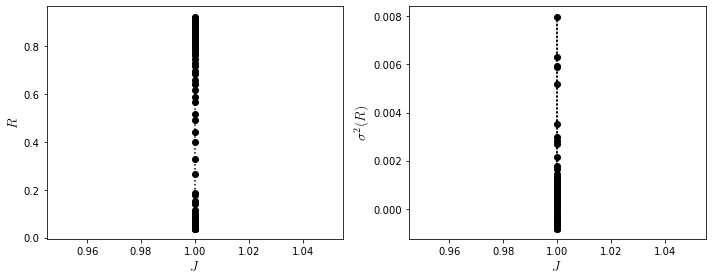

In [39]:
path = "./../data/pd/"
name = "erdos-renyi_kuramoto"

nparts = 9


data = np.empty((0,3))
for part in range(nparts):
    datafile = np.loadtxt(path + name + "_part{0}".format(part))
    data = np.append(data, datafile, axis=0)
del datafile

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].plot(data[:,0], data[:,1], color="black", marker="o", ls=":")
axes[1].plot(data[:,0], data[:,2], color="black", marker="o", ls=":")

axes[0].set_xlabel(r'$J$', fontsize=14, usetex=True)
axes[0].set_ylabel(r'$R$', fontsize=14, usetex=True)

axes[1].set_ylabel(r'$\sigma^2(R)$', fontsize=14, usetex=True)
axes[1].set_xlabel(r'$J$', fontsize=14, usetex=True)

plt.tight_layout()

plt.savefig(SAVEPATH + name + "_pd.pdf")
plt.show()

# Time trace analysis
This one takes the phases of all oscillators, and, knowing the structure of the network, gets the synchronization dynamics of all hierarchical layers

In [36]:
def kuramoto(phases):
    return np.mean(np.exp(1.0j * phases), axis=1)

def time_trace_analysis(filename, n_com, layer, dt=0.01, max_plots=30, savefig=None):
    """
    n_com: array that says how much communities are inside a given one
    layer: which hierarchical layer we want to get. Starts at 1
    dt: to set the correct temporal scale of the X axis, timestep used in simulation
    max_plots: maximum number of lines to show at once
    """
    
    n_levels = np.size(n_com)

    if layer!="all" and (layer < 0 or layer > n_levels):
        print("Layer has to be between 1 and the number of layers, or to be 'all'")
        return
        
    #Load data and get its size
    phases = np.loadtxt(filename)
    
    n = np.size(phases[0,:])
    tsteps = np.size(phases[:,0])
    
    #Generate X axis
    t = np.linspace(0, tsteps * dt, tsteps)
    
    if layer=="all":
        for layer in range(1,n_levels+1):
            #Number of neurons in each group
            n_layer = np.prod(n_com[:layer])
            n_groups = n // n_layer

            #Colors
            n_plots = min(max_plots, n_groups)
            cmap = cmaps.get_cmap('cividis')    

            plt.figure()
            for j in range(n_plots):
                z = kuramoto(phases[:,j*n_layer:(j+1)*n_layer])
                plt.plot(t, np.abs(z), color = cmap(j/n_plots))
            plt.xlabel("$t$")
            plt.ylabel("$R$")
            plt.tight_layout()
            if savefig != None:
                plt.savefig(SAVEPATH+"timetrace/{name}_layer{l}.pdf".format(name=savefig, l=layer), bbox_inches="tight")
            plt.close()
    else:
        #Number of neurons in each group
        n_layer = np.prod(n_com[:layer])
        n_groups = n // n_layer

        #Colors
        n_plots = min(max_plots, n_groups)
        
        cmap = cmaps.get_cmap('seismic')    

        plt.figure()
        for j in range(n_plots):
            z = kuramoto(phases[:,j*n_layer:(j+1)*n_layer])
            plt.plot(t, np.abs(z), color = cmap(j/n_plots))
            print(cmap(j/n_plots))
        plt.xlabel("$t$")
        plt.ylabel("$R$")
        plt.tight_layout()
        if savefig != None:
            plt.savefig(SAVEPATH+"timetrace/"+savefig, bbox_inches="tight")
        plt.close()
    

In [20]:
n_layer = [100,5,3,2]
#n_layer = [10,10,10]

time_trace_analysis("../data/timetrace/r4_trace3", n_layer, "all")

ValueError: could not convert string to float: '9759.0210103.923'

In [37]:
network_structure = {"erdos-renyi":[10,10,10], "r4": [100,5,3,2], "c4": [100,5,3,2], "rb7": [30,2,2,2,2,2,2,2], "cb7":[30,2,2,2,2,2,2,2]}

a_list = [0.0, 0.0, 0.0, 0.5, 0.5, 0.5, 0.9, 1.1, 1.07, 0.9, 1.1, 1.0]
s_list = [0.8, 1.0, 1.2, 0.8, 0.9, 1.0, 0.5, 0.5, 0.5, 0.1, 0.1, 0.1]
name_list = ["hopf_sub", "hopf_crit", "hopf_super", "hopf_exc_sub", "hopf_exc_crit", "hopf_exc_super", "hyb_sub", "hyb_crit", "hyb_super", "snic_sub", "snic_crit", "snic_super"]

for network in network_structure:
    print(network)
    n_layer = network_structure[network]
    for a,s,name in zip(a_list, s_list, name_list):
        time_trace_analysis("../data/timetrace/" + network + name + "_trace0", n_layer, "all", savefig=network + name)

erdos-renyi
r4
c4
rb7
cb7


## Correlations and Functional connectivity

Implementation of functional connectivity measures, trying to get functional connectivity matrices

In [ ]:
def time_trace_analysis(filename, n_com, layer, dt=0.01, max_plots=30):
    """
    n_com: array that says how much communities are inside a given one
    layer: which hierarchical layer we want to get. Starts at 1
    dt: to set the correct temporal scale of the X axis, timestep used in simulation
    max_plots: maximum number of lines to show at once
    """
    
    n_levels = np.size(n_com)

    if layer!="all" and (layer < 0 or layer > n_levels):
        print("Layer has to be between 1 and the number of layers, or to be 'all'")
        return
        
    #Load data and get its size
    phases = np.loadtxt(filename)
    
    n = np.size(phases[0,:])
    tsteps = np.size(phases[:,0])
    
    #Generate X axis
    t = np.linspace(0, tsteps * dt, tsteps)
    
    if layer=="all":
        for layer in range(1,n_levels+1):
            print(layer)
            #Number of neurons in each group
            n_layer = np.prod(n_com[:layer])
            n_groups = n // n_layer

            #Colors
            n_plots = min(max_plots, n_groups)
            cmap = cmaps.get_cmap('cividis')    

            plt.figure()
            for j in range(n_plots):
                z = kuramoto(phases[:,j*n_layer:(j+1)*n_layer])
                plt.plot(t, np.abs(z), color = cmap(j/n_plots))
            plt.show()
    else:
        #Number of neurons in each group
        n_layer = np.prod(n_com[:layer])
        n_groups = n // n_layer

        #Colors
        n_plots = min(max_plots, n_groups)
        
        cmap = cmaps.get_cmap('seismic')    

        plt.figure()
        for j in range(n_plots):
            z = kuramoto(phases[:,j*n_layer:(j+1)*n_layer])
            plt.plot(t, np.abs(z), color = cmap(j/n_plots))
            print(cmap(j/n_plots))
        plt.show()